<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/rumple_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rumple Index
### *(author: John Hogland, 12/17/2021)*

This is an example of calculating the rumple_index using python.
In this example we will be using numba, xarray, dask, and numpy to perform fast iterations (C like) through an elevation raster to calculate 3d surface area as described in Jenness 2004 (https://www.fs.usda.gov/treesearch/pubs/20437). Additionally, we will map our newly developed rumple index function to "chunks" and a delayed reading function within [DASK](https://dask.org/).

## Installing and upgrading libraries

In [ ]:
!pip install --upgrade gdown
!pip install --upgrade numba
!pip install --upgrade geopandas
!pip install mapclassify
!pip install --upgrade datascience
!pip install --upgrade gym
!pip install --upgrade folium
!pip install raster_tools

## Import libraries

In [ ]:
from numba import jit, prange
import xarray as xr
import numpy as np
import rioxarray

# Creating A Fast Processing Function
Next, let's create a function to calculate surface area from a 3 by 3 moving window as described by Jenness 2004 and divide by the area of the 2d cell. Note, to speed up processing we will be using numba to convert our for loops into C code. 


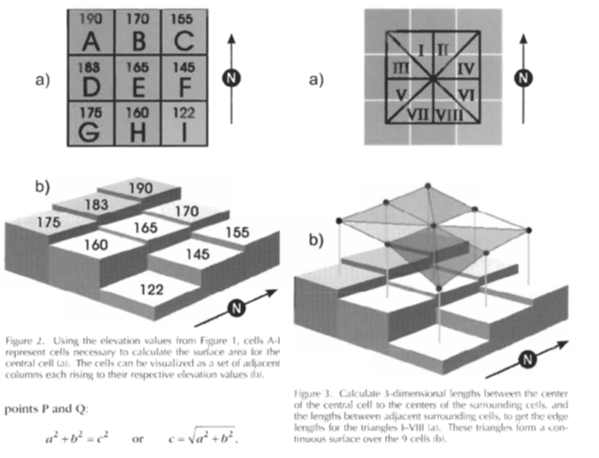

In [ ]:
@jit('f8[:,:](f8[:,:],f8)',nopython=True,nogil=True) #decorator to numba for compiling to C
def _area3d(x,res): #x=in elevation array, outx = out array of zeros, res=resolution of the raster cell
    dd=(res**2)*2
    sd=res**2
    outx = np.zeros_like(x)
    #loop through all cells skipping the first and last rows and columns with a 3 by 3 moving window
    for rw in range(1,x.shape[0]-1):
        for cl in range(1,x.shape[1]-1):
            ta = 0 #variable to store total 3d surface area
            e=x[rw,cl] #center elevation value
            a=x[rw+1,cl-1] #top left
            b=x[rw+1,cl] #top
            c=x[rw+1,cl+1] #top right
            d=x[rw,cl-1]   #left
            f=x[rw,cl+1] #right
            g=x[rw-1,cl-1] #bottom left
            h=x[rw-1,cl] #bottom
            i=x[rw-1,cl+1] #bottom right
            #3d line lengths
            ea=((dd+(e-a)**2)**0.5)*0.5
            eb=((sd+(e-b)**2)**0.5)*0.5
            ab=((sd+(a-b)**2)**0.5)*0.5
            #area calculation
            si=(ea+eb+ab)*0.5
            ta+=(si*(si-ea)*(si-eb)*(si-ab))**0.5
            #3d line lengths
            ec=((dd+(e-c)**2)**0.5)*0.5
            bc=((sd+(b-c)**2)**0.5)*0.5
            #area calculation
            si=(ec+eb+bc)*0.5
            ta+=(si*(si-ec)*(si-eb)*(si-bc))**0.5
            #3d line lengths
            ef=((sd+(e-f)**2)**0.5)*0.5
            cf=((sd+(c-f)**2)**0.5)*0.5
            #area calculation
            si=(ec+ef+cf)*0.5
            ta+=(si*(si-ec)*(si-ef)*(si-cf))**0.5
            #3d line lengths
            ei=((dd+(e-i)**2)**0.5)*0.5
            fi=((sd+(f-i)**2)**0.5)*0.5
            #area calculation
            si=(ei+ef+fi)*0.5
            ta+=(si*(si-ei)*(si-ef)*(si-fi))**0.5
            #3d line lengths
            eh=((sd+(e-h)**2)**0.5)*0.5
            hi=((sd+(h-i)**2)**0.5)*0.5
            #area calculation
            si=(ei+eh+hi)*0.5
            ta+=(si*(si-ei)*(si-eh)*(si-hi))**0.5
            #3d line lengths
            eg=((dd+(e-g)**2)**0.5)*0.5
            gh=((sd+(g-h)**2)**0.5)*0.5
            #area calculation
            si=(eg+eh+gh)*0.5
            ta+=(si*(si-eg)*(si-eh)*(si-gh))**0.5
            #3d line lengths
            ed=((sd+(e-d)**2)**0.5)*0.5
            dg=((sd+(d-g)**2)**0.5)*0.5
            #area calculation
            si=(eg+dg+ed)*0.5
            ta+=(si*(si-eg)*(si-ed)*(si-dg))**0.5
            #3d line lengths
            ad=((sd+(a-d)**2)**0.5)*0.5
            si=(ea+ed+ad)*0.5
            #area calculation
            ta+=(si*(si-ea)*(si-ed)*(si-ad))**0.5
            outx[rw,cl]=ta #set the total surface area to the cell in the outx array
    return outx

# Uploading an Elevation Raster Dataset
Now let's create a directory within our profile on Colab and upload an elevation raster dataset. Note, we could also mount google drive and upload to to a location there. If you don't want to upload data, skip this step and go to Making Data Instead of Uploading.

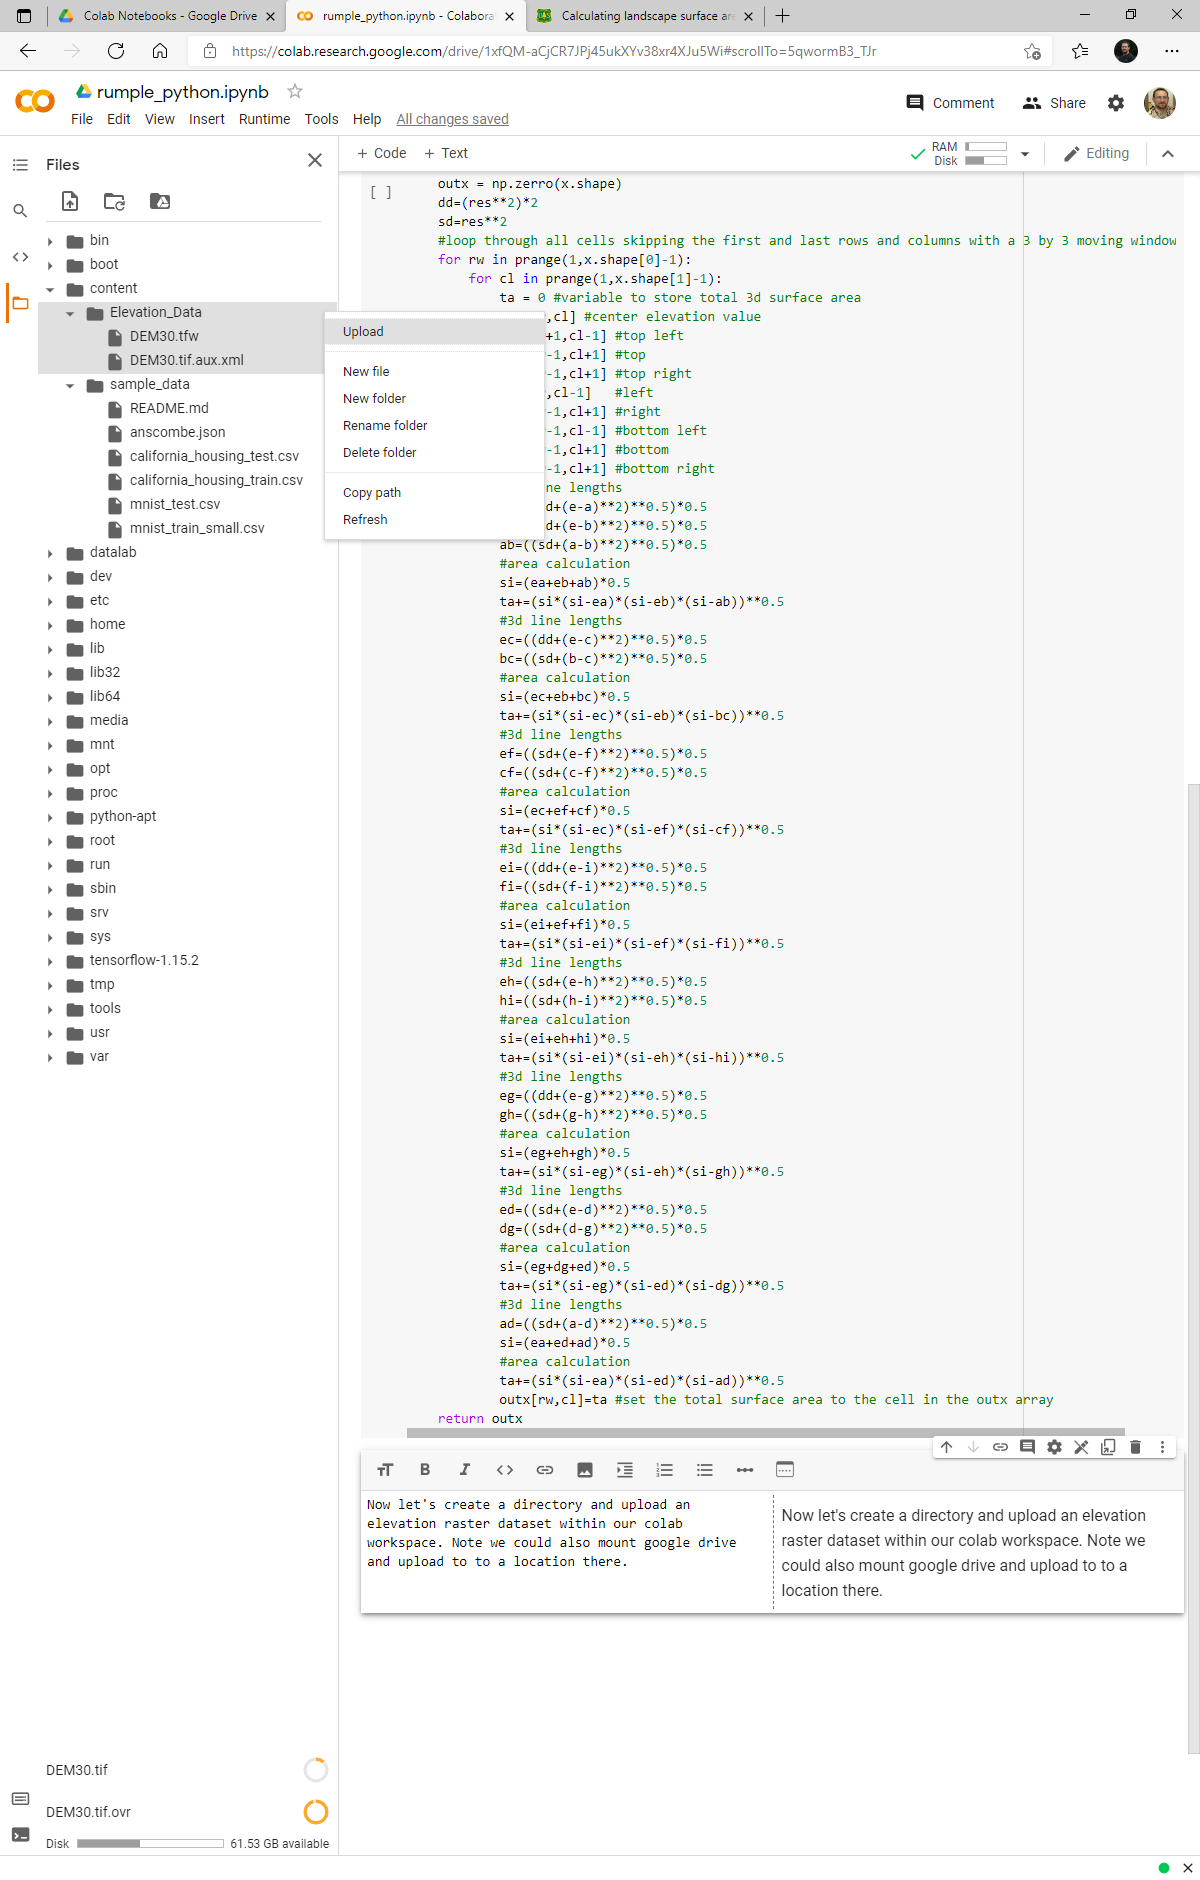

# Openning Data With xarray and rasterio
Xarray and rasterio have made this easy with a simple open function. Behind the scenes if you are using rasterio gdal is being used.

In [ ]:
elevPath=r'/content/Elevation_Data/DEM30.tif' #full path is content\Elevation_Data\...
rs = xr.open_rasterio(elevPath).astype(float) #open the raster and make sure the valeus are floating point for our _area3d function
rs

# Making Data Instead of Uploading

If you don't want to upload data of your own, we can make some random data for this example. If you already have uploaded data, skip this step and go to the Create Rumple Index Raster section.

In [ ]:
import os
elevValues = np.random.randint(low=400,high=2000,size=([3808,2944])).astype(float) #make a random 2d array of elevation values
rs = xr.DataArray(elevValues[None],attrs={'res':(30.0,30.0)},dims={'band':0,'y':1,'x': 2})
#make the Elevation_Data directory if it does not exist for the rest of the examples
elevDirPath = '/content/Elevation_Data'
if(not os.path.exists(elevDirPath)):
  os.mkdir(elevDirPath)

# Create Rumple Index Raster
Now let's create the 3d surface raster divided by the cell area by specifying the path to the elevation raster and calling our _3dArea function.

In [ ]:
rs.values= rs.values #make sure it is a float
rs2=rs.copy()
sur_3d_area = _area3d(rs.values[0],rs.res[0]) #call the function which return a 3d surface distance
rs2.values[0] = sur_3d_area/(rs.res[0]**2) #divide 3d surface area by 2d area

# Plotting the Results
Now let's look at the new surface

In [ ]:
rs2.plot()

# Saving the Results
Now let's save the array to a tif format and download it from our Elevation_Data folder

In [ ]:
outpath = 'Elevation_Data/surfaceArea.tif'
rs2.rio.to_raster(outpath)

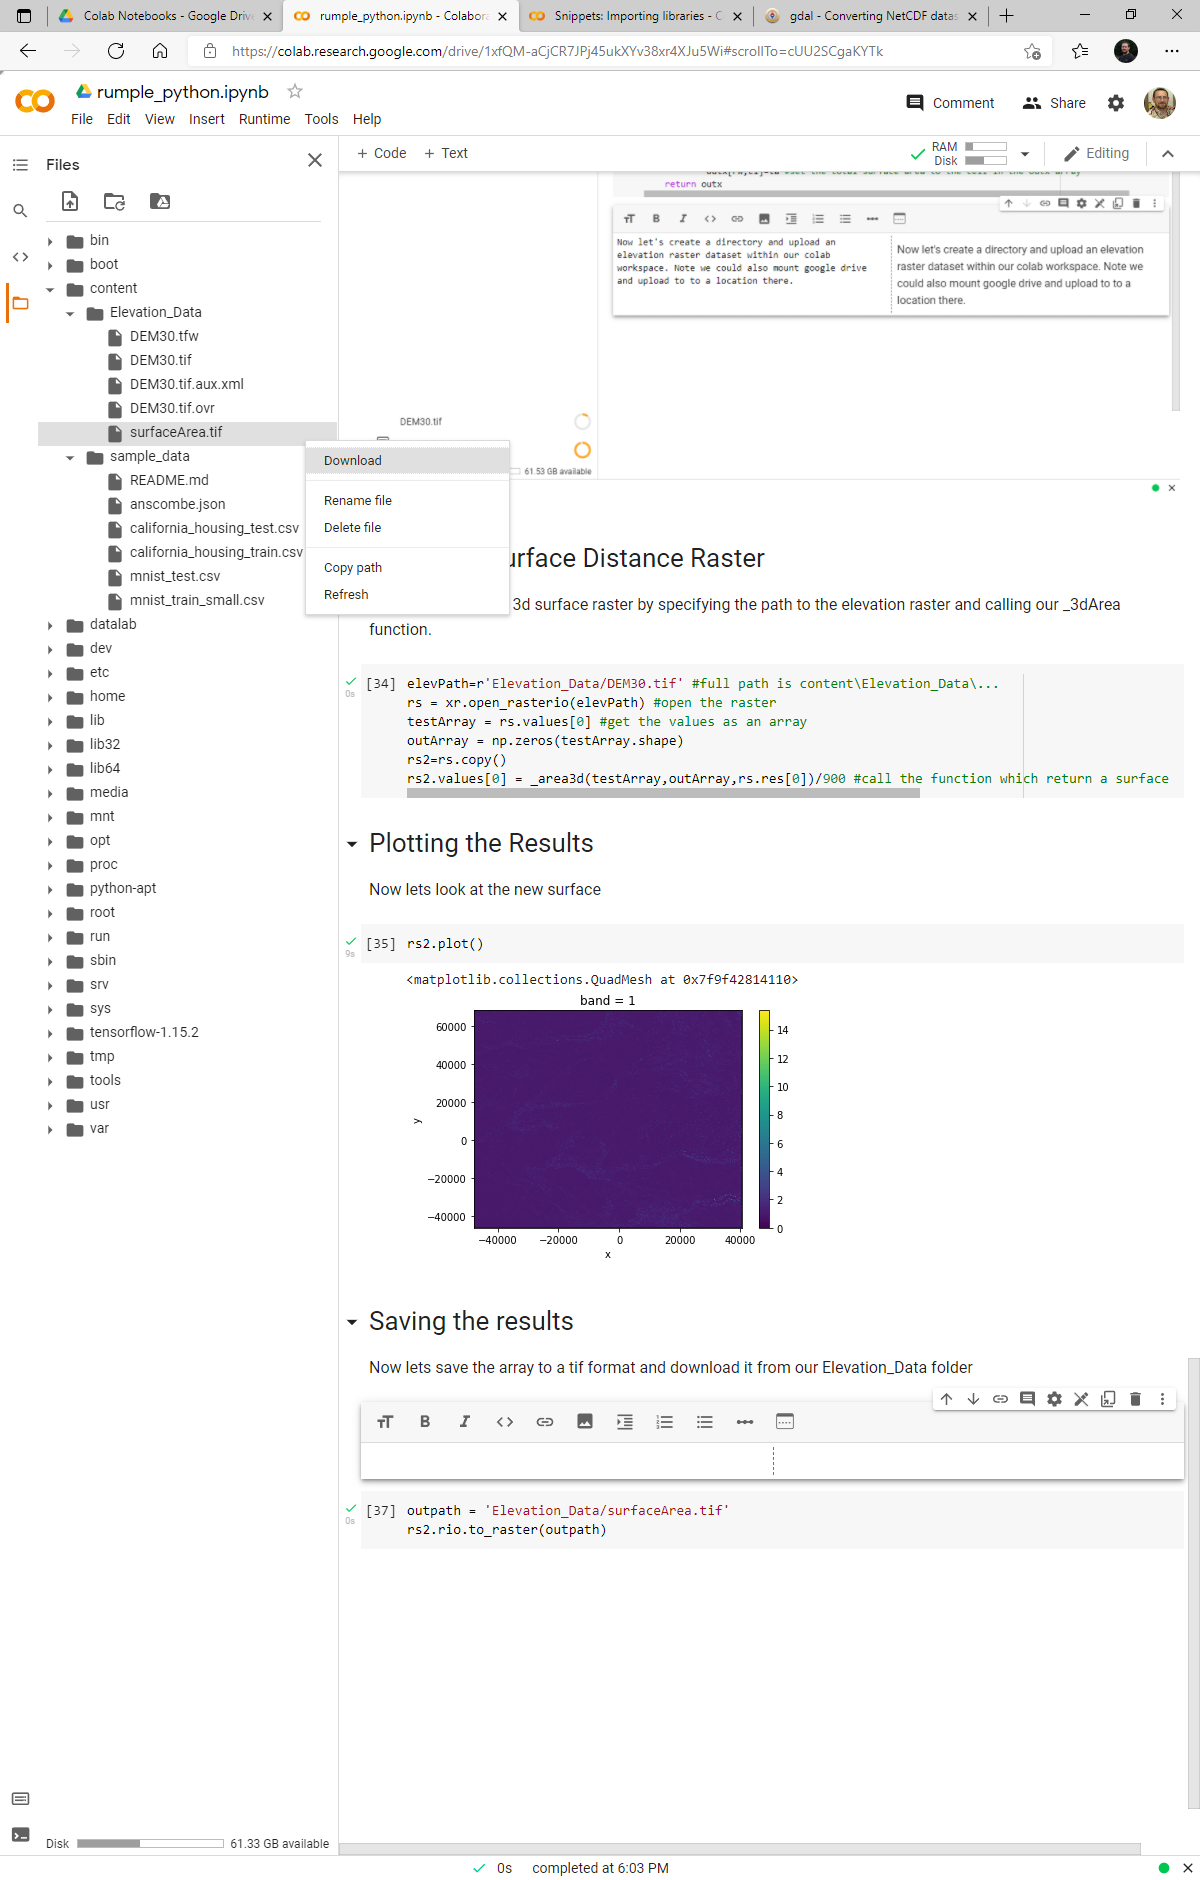

# **Delayed Function and Parallelization**

Now that we have a fast processing rumple index function, let's design it so the function can be split across chunks and convert it into a delayed function within dask. [Chunks](https://docs.dask.org/en/stable/array-chunks.html) can be thought of as subsets of the entire dataset and can be used to reduce RAM needed to process data arrays and makes scheduling across threads easy and automated. The [map_overlap](https://docs.dask.org/en/stable/array-overlap.html) function within DASK makes this easy. Moreover, it has parameters to address the need for overlapping regions across chunks (depth) and how to deal with boundary cells. In addition, we will be leveraging the partial function within functools to partially assign parameters within our _area3d function. 

In [ ]:
from functools import partial
from dask import array as da

data = da.array(rs.data)
func_area3d=partial(_area3d,res=rs.res[0]) #partially assign parameter (res) with the _area3d function
b1 = da.array(data[0].map_overlap(func_area3d,depth={0:1,1:1},boundary=np.nan,dtype=data[0].dtype,meta=np.array((), dtype=data.dtype)))/(rs.res[0]**2) #map overlay to address boarder pixels padding
rs3=xr.DataArray(b1[None],attrs=rs.attrs,coords=rs.coords) #pad b1 so that we have a multiband raster like rs and make a new xarray but with a dask array for delayed reading
rs3 #look at the data

Notice that when we run this as a delayed process it takes 0 seconds to process. Also notice that when we look at rs3 it returns the dask array. This is because the array is now a delayed array and the function still needs to be performed. Let's visualize the process flow and then run the function by calling the compute method through the values property.

# **Visualize the Processing Flow**

In [ ]:
rs3.data.visualize() #simple visualization

# **Computing the Array Values as a Dask Array**
Also, let's save out the results as a tif like we did before. Note, we will be computing 3 times here; once with the mean call, once to save, and once to plot.

In [ ]:
print(rs3.mean().values)
outpath = 'Elevation_Data/surfaceAreaDelayed.tif'
rs3.rio.to_raster(outpath)
rs3.plot()

# **Running the Process in Parallel**
We can now visualize the process flow, have delayed the processing, and are having dask schedule the processing. However, when we look at the number of chunks we see there is just 1. That means that when processing we are only using one thread. How can we get both threads going? Rechunk our data so the scheduler uses both threads. Depending on the size of your raster this may actually add to the processing time due to the added time to schedule the processes. For our raster we will rechunk evenly across the y axis (3808/2).

In [ ]:
rs4= rs3.chunk((1, 1904, 2944)) #making 2 chunks
rs4

Notice the difference in the processing diagram

In [ ]:
rs4.data.visualize()

Now lets compute the mean 50 times for rs3 and rs4 and look at the processing times. Remember a shortcut to compute uses the values property.

In [ ]:
t = 0
for i in range(50):
  t+=rs3.mean().values

t

In [ ]:
t = 0
for i in range(50):
  t+=rs4.mean().values

t


# This Ends the Rumple Index Example
In our example we explored aspects of xarray, dask, fast C like iteration, delayed reading, parallel processing, chunking, and mapping functions to dask arrays. We used chunking to illustrate how one could parallelize the data and employ processing on both threads within Google Colab. However, dask can also be used to auto chunk arrays which makes it easy to scale our code across various system. For example, try loading a larger elevation dataset within the "Uploading an Elevation..." section or change the array size in the "Making Data Instead..." section. Note, you probably do not want to rechunk your data in "Running the Process in Parallel" section and you might want to reduce the number of iterations for rs3 (no need to run for r4. The data are already chunked and being run in parallel).    